## Dataset

In [1]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

mnist = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

train, valid, test = random_split(mnist, lengths=[.75, .1, .15])

train_loader = DataLoader(train, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid, batch_size=64, shuffle=False)
test_loader = DataLoader(test, batch_size=64, shuffle=False)

len(train), len(valid), len(test)

(45000, 6000, 9000)

## Model

In [3]:
# pytorch
import torch
from torch import tensor
import torch.nn as nn

# lightning
import pytorch_lightning as L

# other
import os
import pandas as pd
import matplotlib.pyplot as plt

2024-06-13 01:38:23.991227: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [74]:
class ConvLayer(nn.Module):
    def __init__(self, n_kernels):
        super().__init__()

        kernel_size = 5
        padding = int((kernel_size - 1) / 2) # this is the formula to preserve size assuming a stride of 1

        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=1,
                      out_channels=n_kernels,
                      kernel_size=kernel_size,
                      stride=1,
                      padding=padding),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # this downsamples the input by factor of 2
        )

    def forward(self, x):
        return self.layer(x)

class DeConvLayer(nn.Module):
    def __init__(self, n_kernels):
        super().__init__()

        kernel_size = 5
        padding = int((kernel_size - 1) / 2)

        self.layer = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=1,
                      out_channels=n_kernels,
                      kernel_size=kernel_size,
                      stride=2,
                      padding=padding,
                      output_padding=1
                      ),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.layer(x)


conv = ConvLayer(1)

ex_input = torch.randn(1, 28, 28)
output = conv(ex_input)

encoder = Encoder(1)
output = encoder(ex_input)

# ---

deconv = DeConvLayer(1)
output = deconv(ex_input)

decoder = Decoder(1)
output = decoder(encoder(ex_input))

output.shape

torch.Size([1, 28, 28])

In [54]:
class Encoder(nn.Module):
    def __init__(self, n_downsamples):
        super().__init__()

        self.layers = nn.ModuleList()
        for _ in range(n_downsamples):
            self.layers.append(ConvLayer(1))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return x


class Decoder(nn.Module):
    def __init__(self, n_upsamples):
        super().__init__()

        self.layers = nn.ModuleList()
        for _ in range(n_upsamples):
            self.layers.append(DeConvLayer(1))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return x


class ConvAutoencoder(L.LightningModule):
    def __init__(self, n_downsamples: int):
        super().__init__()
        n_upsamples = n_downsamples

        self.loss_fn = nn.MSELoss()

        self.encoder = Encoder(n_downsamples)
        self.decoder = Decoder(n_upsamples)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def training_step(self, batch, batch_idx):
        x, _ = batch
        y = x # because autoencoder

        output = self.forward(x)
        loss = self.loss_fn(output, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, _ = batch
        y = x # because autoencoder

        output = self.forward(x)
        loss = self.loss_fn(output, y)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        x, _ = batch
        y = x # because autoencoder

        output = self.forward(x)
        loss = self.loss_fn(output, y)
        self.log('test_loss', loss)

    def configure_optimizers(self):
        return torch.optim.Adam(lr=0.001, params=self.parameters())


In [78]:
log_save_dir = 'autoencoder_logs'

model = ConvAutoencoder(1)

trainer = L.Trainer(
    logger=L.loggers.CSVLogger(save_dir=log_save_dir),
    max_epochs=1
)

trainer.fit(
    model, 
    train_loader, 
    valid_loader,
)

logs_df = get_latest_logs_as_df(log_save_dir)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type    | Params
------------------------------------
0 | loss_fn | MSELoss | 0     
1 | encoder | Encoder | 26    
2 | decoder | Decoder | 26    
------------------------------------
52        Trainable params
0         Non-trainable params
52        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


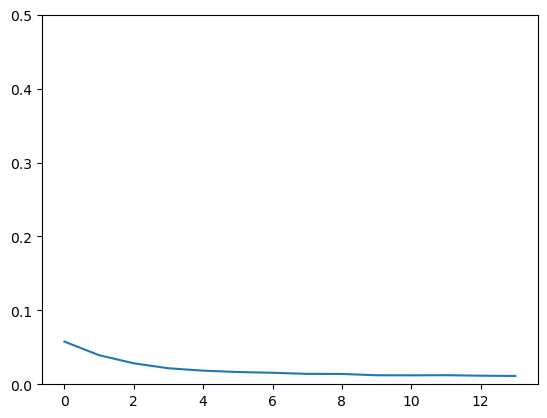

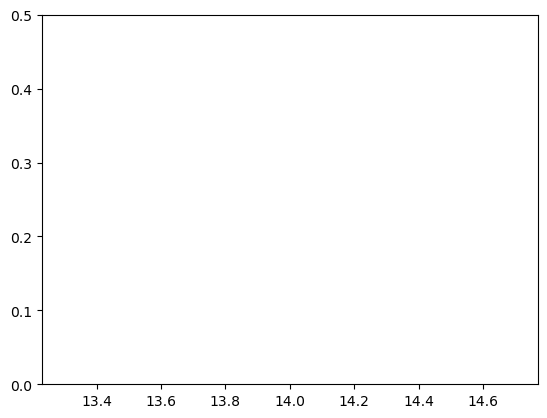

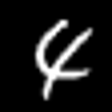

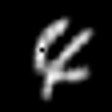

In [79]:
# logs_df

logs_df.train_loss.plot()
plt.ylim(0, .5)
plt.show()
logs_df.val_loss.plot()
plt.ylim(0, .5)
plt.show()


# visual test

test_ex = test[0][0]
display_tensor_as_image(test_ex)
display_tensor_as_image(model(test_ex))

## Visualization utils

In [77]:
from pathlib import Path

def get_latest_logs_as_df(log_save_dir) -> pd.DataFrame:
    log_versions_dir = f'{log_save_dir}/lightning_logs'
    latest_log_dir = os.listdir(log_versions_dir)[-1]
    latest_csv = f'{log_versions_dir}/{latest_log_dir}/metrics.csv'

    return pd.read_csv(latest_csv)


def display_tensor_as_image(tensor):
    to_img = transforms.ToPILImage()
    tensor = tensor.view(28, 28)
    img: Image.Image = to_img(tensor)
    img = img.resize((28*4, 28*4))
    display(img)
